<h1> Fashion classification </h1>

Data set:

https://www.kaggle.com/datasets/zalando-research/fashionmnist

- Each row is a separate image

- Column 1 is the class label.

- Remaining columns are pixel numbers (784 total).

- Each value is the darkness of the pixel (1 to 255)

<h2> Project goals </h2>

- CLassification of labeled data using softmax regression classifier

- Practical use of the knowledge of chapters 2 and 4 of the book: Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow.

<h2> Functions </h2>

In [11]:
def describe_fashion(x, y):
    """
    Describes given fashion.
    input: x - row of X, y - target value
    """
    
    fashion = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover',
               3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt',
               7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}
    
    pixels_to_image(x, 28, 28)
    
    print(fashion[y])

<h2> Settings and libraries </h2>

In [2]:
import pandas as pd
# import opendatasets as od
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, GridSearchCV
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, roc_curve, roc_auc_score

%run ml_functions.ipynb
%run custom_transformers.ipynb

In [3]:
# od.download(
#     "https://www.kaggle.com/datasets/zalando-research/fashionmnist")

<h2> First look </h2>

In [4]:
df_train = pd.read_csv("fashionmnist/fashion-mnist_train.csv")
df_test = pd.read_csv("fashionmnist/fashion-mnist_test.csv")

In [5]:
df_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
print(df_train.shape)
print(df_test.shape)

(60000, 785)
(10000, 785)


Separate class label column.

In [7]:
y_train = df_train["label"]
X_train = df_train.drop("label", axis=1)

y_test = df_test["label"]
X_test = df_test.drop("label", axis=1)

Convert numerical dfs to numpy arrays.

In [8]:
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

Show sample cloth.

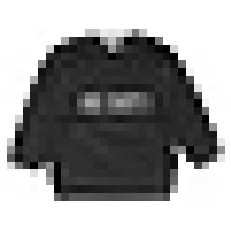

Pullover


In [12]:
describe_fashion(X_train[0], y_train[0])

Check for nans

In [13]:
df_train.isnull().values.any()

False

Check if columns are constant or quasi-constant.

In [14]:
selector = VarianceThreshold(0.01)
selector.fit_transform(df_train)
df_train.shape[1] - sum(selector.get_support())

1

There is only 1 quasi-column for 0.01 threshold.

There is no const. columns.

Labels distribution

In [15]:
df_train["label"].value_counts()

9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
Name: label, dtype: int64

Labels are equally distributed.

<h2> Data preprocessing </h2>

In [16]:
X = X_train.copy()

Standarization

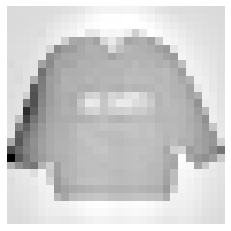

Pullover


In [17]:
X = X_train.copy()

pipeline_scaler = Pipeline([
    ('std_scaler', StandardScaler()),
    ])

X_scaled = pipeline_scaler.fit_transform(X)
describe_fashion(X_scaled[0], y_train[0])

Black = 0 and white > 1:

In [19]:
# X = X_train.copy()

# pipeline_binary0 = Pipeline([
#     ('pixel_to_binary', PixeltoBinary()),
#     ])

# X_binared0 = pipeline_binary0.fit_transform(X)
# describe_fashion(X_binared0[0], y_train[0])

# np.count_nonzero(X_binared0) / np.product(X_binared0.shape)

# print('On average half of the pixels on an image are not white.'')

In [20]:
#print('Black <= 128 and white > 128:'')

# X = X_train.copy()

# pipeline_binary128 = Pipeline([
#     ('pixel_to_binary', PixeltoBinary(floor=128)),
#     ])

# X_binared128 = pipeline_binary128.fit_transform(X)
# describe_fashion(X_binared128[0], y_train[0])

In [21]:
# print('Constant and quasi-constant columns')

# X = X_train.copy()

# columns = np.arange(0, X_train.shape[1], 1)

# pipeline_constant = ColumnTransformer([
#  ("num", DropConstantColumn(threshold=0.01), columns),
#  ])

# X_noconst = pipeline_constant.fit_transform(X)

<h2> Softmax regression classifier </h2>

Now we will use softmax regression classifier usinf sklearn, for prediction.

As we know, it's preferable to have at least a little bit of regularization. Lasso or Elastic Net are a good choices, if we suspect, that only a few features have a big impact. It's not our case. That's why we will try to regularize with a Ridge. Additonally, we will use early stopping.

Let's begin with a plain model.

In [18]:
X_, X_cv, y_, y_cv = train_test_split(X_scaled, y_train, test_size=0.2, random_state=42)

In [36]:
model = LogisticRegression(penalty='none', multi_class='multinomial', fit_intercept=False, max_iter=100)

model.fit(X_, y_)

/home/areczek/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(fit_intercept=False, multi_class='multinomial',
                   penalty='none')

In [64]:
y_cv_pred = cross_val_predict(model, X_cv, y_cv)
y_cv_pred_proba = cross_val_predict(model, X_cv, y_cv, method='predict_proba')

/home/areczek/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/areczek/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model

In [48]:
con = confusion_matrix(y_cv, y_cv_pred)

In [49]:
fashion = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

pd.DataFrame(con, index=fashion, columns=fashion)

,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
T-shirt/top,932,12,36,50,10,6,172,2,12,0
Trouser,8,1113,6,30,7,0,8,1,1,0
Pullover,22,7,844,19,147,3,149,0,8,1
Dress,47,47,30,1003,58,1,49,1,3,3
Coat,9,4,151,57,803,2,150,0,9,0
Sandal,1,1,1,1,0,1007,0,77,16,37
Shirt,191,6,165,45,126,2,683,0,24,1
Sneaker,0,0,0,0,0,67,0,1108,2,47
Bag,10,4,10,9,6,19,29,9,1048,5
Ankle boot,0,0,0,0,0,30,1,52,2,1125


As we can see our model is often wrong, when predicting T-shirt/Top, Pullover, Coat and Shirt, which are intuitively most similar parts of clothing.

Let's measure precision, recall and F1 score.

In [53]:
precision, recall, f1_score = precision_recall_fscore_support(y_cv, y_cv_pred)[:3]

In [56]:
np.average(precision), np.average(recall), np.average(f1_score)

(0.8072198150520127, 0.8072187825077579, 0.8071471966564465)

Generally, F1 favors classifiers which have similar precision and recall, and this is what we want in our case, so it will be our performance measure and there is no need to experiment with precision/recall tradeoff. Additionally, F1 score is preffered for multiclass classification over ROC AUC.

<h3> Hyperparameter tuning </h3>

In [70]:
model = LogisticRegression(multi_class='multinomial', max_iter=400, random_state=42, penalty='l2')

parameters = {'C': [10, 1, 0.1, 0.01, 0.001],
              'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']}

model = GridSearchCV(model, parameters)

model.fit(X_, y_)

/home/areczek/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/areczek/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/areczek/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/areczek/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/areczek/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increas

GridSearchCV(estimator=LogisticRegression(max_iter=400,
                                          multi_class='multinomial',
                                          random_state=42),
             param_grid={'C': [10, 1, 0.1, 0.01, 0.001],
                         'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']})

Even if we set max_features hyperparameter to 1000, max_iter is reached for the models that warnings refer to, what I check on Google Colab:

https://colab.research.google.com/drive/1hB2aPWlFX2shlonTnbtdNvft4jGQ9FQp?usp=sharing

Let's check model of which parameters was best and tune again.

In [75]:
model.best_params_

{'C': 0.01, 'solver': 'newton-cg'}

In [24]:
model = LogisticRegression(multi_class='multinomial', max_iter=400, random_state=42, penalty='l2', solver='newton-cg')

parameters = {'C': [0.003, 0.005, 0.01, 0.03, 0.05] }

model = GridSearchCV(model, parameters)

model.fit(X_, y_)

GridSearchCV(estimator=LogisticRegression(max_iter=400,
                                          multi_class='multinomial',
                                          random_state=42, solver='newton-cg'),
             param_grid={'C': [0.003, 0.005, 0.01, 0.03, 0.05]})

In [25]:
model.best_params_

{'C': 0.01}

In [27]:
model = model.best_estimator_

As we can see a best finded model is for newton-cg solver and C=0.01. Let's make some predictions.

In [29]:
y_cv_pred = cross_val_predict(model, X_cv, y_cv)
y_cv_pred_proba = cross_val_predict(model, X_cv, y_cv, method='predict_proba')

In [33]:
precision, recall, f1_score = precision_recall_fscore_support(y_cv, y_cv_pred)[:3]

In [34]:
np.average(precision), np.average(recall), np.average(f1_score)

(0.8427606975984322, 0.8434101913763603, 0.8428416182741575)

As we can see with a pretty similar values of precision and recall f1_score equals around 0.84. It's better than before (f1_score was equal around 0.81).

It's time for error analysis.

In [35]:
con = confusion_matrix(y_cv, y_cv_pred)

fashion = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

pd.DataFrame(con, index=fashion, columns=fashion)

,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
T-shirt/top,1009,6,16,57,3,5,125,0,11,0
Trouser,6,1116,9,35,3,0,5,0,0,0
Pullover,14,2,892,11,157,0,117,0,7,0
Dress,44,14,13,1088,48,0,32,0,3,0
Coat,3,4,116,49,893,0,115,0,5,0
Sandal,2,0,1,2,0,1033,0,70,9,24
Shirt,194,4,135,41,129,2,718,0,19,1
Sneaker,0,0,0,0,0,56,0,1130,0,38
Bag,8,1,5,10,2,8,26,7,1080,2
Ankle boot,0,1,0,0,0,20,1,43,1,1144


At first glance, errors of recognizing clothes are the same type as before. It's time to use matshow function.

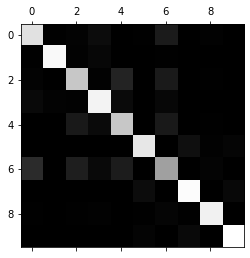

In [37]:
plt.matshow(con, cmap=plt.cm.gray)
plt.show()

Most of instances were classified correctly, that's why main diagonal is bright. However indexes 0,2,4 and 6 are darker than others. It could mean that, there are fewer images of this kind or classifier doesn't perform that good for these clothes. As we know labels are quite good balanced, also the dataset opts for the second idea.

Let's focus our plot on errors. We will replace pure number with ratios (divide each value by number of instances of corresponding class) and set 0 for diagonal.

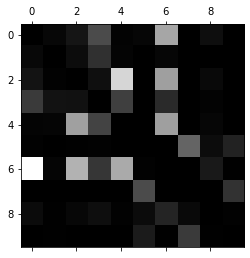

In [39]:
row_sums = con.sum(axis=1, keepdims=True)
normalized_con = con / row_sums

np.fill_diagonal(normalized_con, 0)
plt.matshow(normalized_con, cmap=plt.cm.gray)
plt.show()

Columns with index 4 and 6 are quire bright, which means many of instances get missclassified as Coat or Shirt. Also rows of these clothes are bright. This time, it means that Shirts and Coats are sometimes classified wrong.
As we can see, the biggest error is because of the situation that Shirts are predicted as T-shirts / Tops.
The reason of these errors is a high similarity of these clothes.

Now, our idea is to analyze these errors to gain insights why exactly our classifier makes these wrong predictions and what kind of transformation or additional features may help to imporve predictions.

In [ ]:
Let's start by displaying  1vs1 using imshow...